## Import required modules

In [11]:
import numpy as np
from scipy.optimize import fsolve
from tabulate import tabulate
import matplotlib.pyplot as plt

# Part A - Mach angle and Prandtl-Meyer function
This function takes the upstream mach number and ratio of specific heats (gamma) as an input, and outputs the Prandtl-Meyer function, nu, and the mach angle.

In [14]:
def angle_and_prandlt(mach, gamma):
    temp = (gamma+1)/(gamma-1)
    nu = ((temp**0.5) * np.arctan(((mach**2 - 1)/temp)**0.5) - np.arctan((mach**2 - 1)**0.5)) * 180/np.pi
    mach_angle = np.arcsin(1/mach) * 180/np.pi
    return(nu, mach_angle)

If you want to run just this function, you can do so in the next cell.

In [16]:
mach = float(input("Upstream mach number: "))
gamma = float(input("Ratio of specific heats: "))
nu, mach_angle = angle_and_prandlt(mach, gamma)
print('')
print('Prandtl-Meyer Function: {}'.format(nu))
print('Mach Angle: {}'.format(mach_angle))

Upstream mach number: 2.5
Ratio of specific heats: 1.7

Prandtl-Meyer Function: 30.595309844810735
Mach Angle: 23.578178478201835


# Part B - Method of Characteristics

In [19]:
rounding = 2 #How many decimal places to round table values too. This only affects displayed values.


# Function to calculate the flow data and coordinates for all method of characteristics points
def moc(gamma, mach, char_lines, start_angle):
    
    # Reverse function to calculate mach number from prandtl-meyer function
    def mach_from_prandtl(prandtl):
        def solve(mach):
            temp = (gamma+1)/(gamma-1)
            nu = ((temp**0.5) * np.arctan(((mach**2 - 1)/temp)**0.5) - np.arctan((mach**2 - 1)**0.5)) * 180/np.pi
            nu = nu-prandtl
            return(nu)
        return(float(fsolve(solve, [1.5])))
    
    # Initialises an array to hold all variables
    lens = int(2*char_lines + (1+char_lines)*char_lines/2)
    array = np.zeros((lens,10))

    # Sets up initial known variables
    nu, theta = angle_and_prandlt(mach, gamma)
    step = ((nu/2)-start_angle)/(char_lines-1)
    for i in range(char_lines):
        array[i][1] = 2*(start_angle+step*i)
        array[i][2] = start_angle+step*i
        array[i][3] = start_angle+step*i
        array[i][4] = mach_from_prandtl(start_angle+step*i)
        array[i][5] = (180/np.pi)*np.arcsin(1/array[i][4])
        array[i][6] = array[i][2]+array[i][5]
        array[i][7] = array[i][2]-array[i][5]
        array[i][9] = 1
        

    # R+ collumn
    temp_var = char_lines
    k = 0
    for i in range(char_lines, lens):
        array[i][0] = array[k][1]
        temp_var -= 1
        if temp_var < 0:
            k+=1
            temp_var = char_lines - k

    # R- collumn
    i = 1
    while(i<char_lines+1):
        diff = char_lines+1
        r_array=np.zeros(i)
        for k in range(i):
            if k == 0:
                r_array[k] = i+char_lines-1
            else:
                r_array[k] = r_array[k-1]+(diff)
            diff-=1
        for r in r_array:
            array[int(r)][1] = array[i-1][1]
        i+=1

    # Fill in remaining flow data
    for i in range(char_lines, lens, 1):
        if array[i][1] != 0:
            array[i][2] = (array[i][1]-array[i][0])/2
            array[i][3] = (array[i][1]+array[i][0])/2
            array[i][4] = mach_from_prandtl(array[i][3])
            array[i][5] = (180/np.pi)*np.arcsin(1/array[i][4])
            array[i][6] = array[i][2]+array[i][5]
            array[i][7] = array[i][2]-array[i][5]
        else:
            array[i][2] = array[i-1][2]
            array[i][3] = array[i-1][3]
            array[i][4] = array[i-1][4]
            array[i][5] = array[i-1][5]
            array[i][6] = array[i-1][6]
            array[i][7] = array[i-1][7]
    
    # Calculates coordinates for point 1 (where line a intersects plane of symmetry)
    BP = 0.5*((array[0][2]-array[0][5])+(array[char_lines][2]-array[char_lines][5]))
    XB = array[0][8]
    YB = array[0][9]
    array[char_lines][8] = XB - (YB/np.tan(BP*np.pi/180))

    # Calculates the coordinate for all other non-wall points
    i = 2
    while(i<char_lines+1):
        diff = char_lines+1
        r_array=np.zeros(i)
        for k in range(i):
            if k == 0:
                r_array[k] = i+char_lines-1
            else:
                r_array[k] = r_array[k-1]+(diff)
            diff-=1
        i+=1
        for r in range(len(r_array)):
            n = int(r_array[r])
            if r == 0:
                AP = 0.5*((array[n-1][2]+array[n-1][5])+(array[n][2]+array[n][5]))
                BP = 0.5*((array[len(r_array)-1][2]-array[len(r_array)-1][5])+(array[n][2]-array[n][5]))
                XA = array[n-1][8]
                XB = array[len(r_array)-1][8]
                YA = array[n-1][9]
                YB = array[len(r_array)-1][9]
                array[n][8] = (XB*np.tan(BP*np.pi/180) - XA*np.tan(AP*np.pi/180) + YA - YB)/(np.tan(BP*np.pi/180) - np.tan(AP*np.pi/180))
                array[n][9] = YA + (array[n][8]-XA)*np.tan(AP*np.pi/180)
            elif r == len(r_array)-1:
                BP = 0.5*((array[int(r_array[r-1])][2]-array[int(r_array[r-1])][5])+(array[n][2]-array[n][5]))
                XB = array[int(r_array[r-1])][8]
                YB = array[int(r_array[r-1])][9]
                array[n][8] = XB - (YB/np.tan(BP*np.pi/180))
            else:
                AP = 0.5*((array[n-1][2]+array[n-1][5])+(array[n][2]+array[n][5]))
                BP = 0.5*((array[int(r_array[r-1])][2]-array[int(r_array[r-1])][5])+(array[n][2]-array[n][5]))
                XA = array[n-1][8]
                XB = array[int(r_array[r-1])][8]
                YA = array[n-1][9]
                YB = array[int(r_array[r-1])][9]
                array[n][8] = (XB*np.tan(BP*np.pi/180) - XA*np.tan(AP*np.pi/180) + YA - YB)/(np.tan(BP*np.pi/180) - np.tan(AP*np.pi/180))
                array[n][9] = YA + (array[n][8]-XA)*np.tan(AP*np.pi/180)

    # Calculates the coordinates for all wall points
    wall_solution=[[0,1]]
    walls=[char_lines-1]
    wall_num=0;
    for i in range(char_lines, lens, 1):
        if array[i][1] == 0:
            walls.append(i)
    for i in range(char_lines, lens, 1):
        if array[i][1] == 0:
            AP = (array[i-1][2]+array[i-1][5])
            BP = 0.5*(array[int(walls[wall_num])][2] + array[i][2])
            XA = array[i-1][8]
            XB = array[int(walls[wall_num])][8]
            YA = array[i-1][9]
            YB = array[int(walls[wall_num])][9]
            array[i][8] = (XB*np.tan(BP*np.pi/180) - XA*np.tan(AP*np.pi/180) + YA - YB)/(np.tan(BP*np.pi/180) - np.tan(AP*np.pi/180))
            array[i][9] = YA + (array[i][8]-XA)*np.tan(AP*np.pi/180)
            wall_solution.append([array[i][8], array[i][9]])
            wall_num+=1
    return(wall_solution, array)


# Uses data from above function and displays it
def method_of_characteristics():
    gamma = float(input("Gamma: "))
    mach = float(input("Exit mach number: "))
    char_lines = int(input("Number of characteristic lines: "))
    start_angle = float(input("Starting angle: "))
    
    # Gets data from above function
    wall_solution, array = moc(gamma, mach, char_lines, start_angle)
    
    # Creates a table of full data with appropriate headers
    table = [['','R+','R-','\u03B8','\u03BD','M','\u03BC','\u03B8 + \u03BC','\u03B8 - \u03BC','X', 'Y']]
    for i in range(char_lines):
        row = []
        row.append(chr(97+i))
        for k in array[i]:
            row.append(round(k,rounding))
        table.append(row)
    for i in range(char_lines, len(array), 1):
        row = []
        row.append(i-char_lines+1)
        for k in array[i]:
            row.append(round(k,rounding))
        table.append(row)
    
    # Displays full data table
    table1 = tabulate(table, tablefmt="simple_grid")
    print('')
    print('Full Table')
    print(table1)
    
    # Displays a second table showing just wall point coordinates. These are also in table 1
    table2=tabulate(wall_solution, headers=['x','y'], tablefmt="simple_grid")
    print('')
    print('Wall Points')
    print(table2)
    
    # Plot characteristic lines
    sym_points=[char_lines]
    for i in range(1, char_lines):
        sym_points.append(sym_points[i-1] + char_lines + 2 - i)
    for i in range(char_lines):
        char_line_plot_x=[0]
        char_line_plot_y=[1]
        char_line_plot_x.append(array[sym_points[i]][8])
        char_line_plot_y.append(array[sym_points[i]][9])
        char_line_plot_x.append(wall_solution[i+1][0])
        char_line_plot_y.append(wall_solution[i+1][1])
        plt.plot(char_line_plot_x, char_line_plot_y)
                                
    
    # Plots wall points, mirrored side, and line of symmetry
    x=[0]
    y1=[1]
    y2=[-1]
    y0=[0]
    for i in array:
        if i[1] == 0:
            x.append(i[8])
            y1.append(i[9])
            y2.append(-1*i[9])
            y0.append(0)
    plt.plot(x,y1, 'b')
    plt.plot(x,y2, 'b')
    plt.plot(x,y0, '--')
    plt.title('Nozzle Dimensions')
    plt.ylabel('y/r')
    plt.xlabel('x/r')
    plt.ylim(min(y2)*1.1,max(y1)*1.1)
    plt.xlim((max(x)*-0.1),max(x)*1.1)
    plt.show()    

# Running the Function

Now you can just run the function below, specifying gamma (ratio of specific heats), the exit mach number, the number of characteristic lines to be used, and the starting angle for the Prandtl-Meyer expansion when prompted.

Gamma: 1.4
Exit mach number: 2.7
Number of characteristic lines: 5
Starting angle: 0.2

Full Table
┌────┬───────┬───────┬───────┬───────┬──────┬───────┬───────┬────────┬───────┬──────┐
│    │ R+    │ R-    │ θ     │ ν     │ M    │ μ     │ θ + μ │ θ - μ  │ X     │ Y    │
├────┼───────┼───────┼───────┼───────┼──────┼───────┼───────┼────────┼───────┼──────┤
│ a  │ 0.0   │ 0.4   │ 0.2   │ 0.2   │ 1.03 │ 76.75 │ 76.95 │ -76.55 │ 0.0   │ 1.0  │
├────┼───────┼───────┼───────┼───────┼──────┼───────┼───────┼────────┼───────┼──────┤
│ b  │ 0.0   │ 11.21 │ 5.6   │ 5.6   │ 1.28 │ 51.43 │ 57.03 │ -45.82 │ 0.0   │ 1.0  │
├────┼───────┼───────┼───────┼───────┼──────┼───────┼───────┼────────┼───────┼──────┤
│ c  │ 0.0   │ 22.01 │ 11.01 │ 11.01 │ 1.47 │ 42.89 │ 53.89 │ -31.88 │ 0.0   │ 1.0  │
├────┼───────┼───────┼───────┼───────┼──────┼───────┼───────┼────────┼───────┼──────┤
│ d  │ 0.0   │ 32.82 │ 16.41 │ 16.41 │ 1.65 │ 37.24 │ 53.65 │ -20.83 │ 0.0   │ 1.0  │
├────┼───────┼───────┼───────┼───────┼───

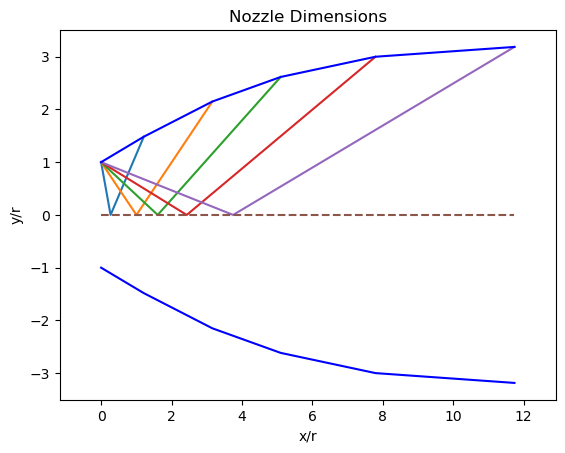

In [20]:
method_of_characteristics()